- price histogram done
- publish date histogramm (year) done
- publish year histogramm done
- genre pi chart (maybe heatmap)
- most rated games
- single vs multi player
- average price over year (maybe with regression model as forecast) done

In [59]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

file_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'steam_data_2021_2025.csv')
df = pd.read_csv(file_path)
print(df.head())

     appid                        name  release_year  release_date  \
0  3057270           Seafarer's Gambit          2024   Jul 5, 2024   
1  3822840    Capitalist Misadventures          2025  Jul 25, 2025   
2  3216640  The Beast and the Princess          2025  Jun 17, 2025   
3  2403620                 Air Twister          2023  Nov 10, 2023   
4  1538040                Horde Slayer          2021  Mar 19, 2021   

                                           genres  \
0             Action;Adventure;Indie;RPG;Strategy   
1                Casual;Indie;Simulation;Strategy   
2                        Adventure;Indie;Strategy   
3                          Action;Adventure;Indie   
4  Action;Adventure;Casual;Indie;RPG;Early Access   

                                          categories  price  recommendations  \
0                       Single-player;Family Sharing   3.99                0   
1          Single-player;Save Anytime;Family Sharing   7.99                0   
2  Single-player;Ste

In [ ]:
df_dedup = df.drop_duplicates('appid')
steam_df = df_dedup.dropna()
steam_df['release_date'] = pd.to_datetime(
    steam_df['release_date'],
    format='mixed',
    errors='coerce'
)
steam_df = steam_df.dropna(subset=['release_date'])
steam_df['year'] = steam_df['release_date'].dt.year
steam_df['month'] = steam_df['release_date'].dt.month_name()

Separate free games from paid games to avoid distorting the price distribution.

Compute the average price of paid games.

Define fixed price ranges to group similar prices together.

Assign each paid game to a price range.

Count how many games fall into each range.

Plot the counts as a bar chart showing the price distribution.

Average price of a paid game: €8.82


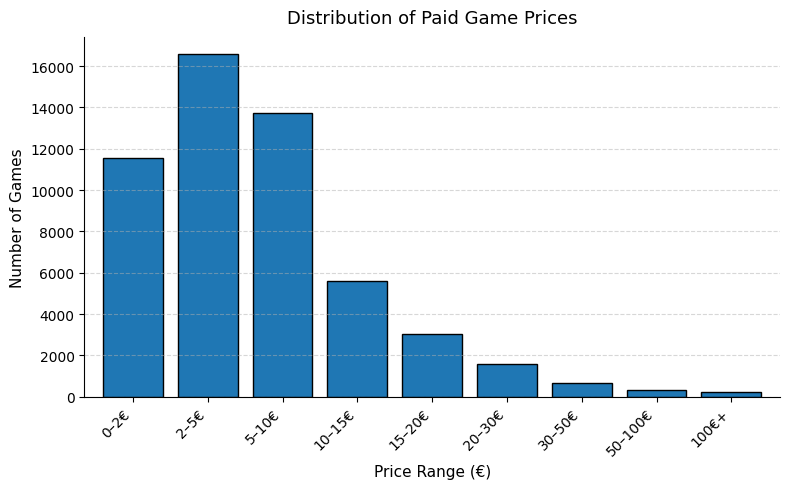

Number of free games: 11554


In [ ]:
free_games = steam_df.loc[steam_df['price'] == 0]
paid_games = steam_df.loc[steam_df['price'] > 0].copy()

average_price = paid_games['price'].mean()
print(f"Average price of a paid game: €{average_price:.2f}")

bins = [0, 2, 5, 10, 15, 20, 30, 50, 100, float('inf')]
labels = [
    "0–2€", "2–5€", "5–10€", "10–15€", "15–20€",
    "20–30€", "30–50€", "50–100€", "100€+"
]

paid_games.loc[:, 'price_bin'] = pd.cut(
    paid_games['price'],
    bins=bins,
    labels=labels,
    right=False
)

price_bin_counts = paid_games['price_bin'].value_counts().sort_index()

plt.figure(figsize=(8, 5))

price_bin_counts.plot(
    kind='bar',
    width=0.8,
    edgecolor='black'
)

plt.xlabel("Price Range (€)", fontsize=11)
plt.ylabel("Number of Games", fontsize=11)
plt.title("Distribution of Paid Game Prices", fontsize=13, pad=10)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)


ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig("price_distribution.png", dpi=300)

plt.show()

print(f"Number of free games: {len(free_games)}")


Convert release dates to datetime format and remove invalid entries.

Extract the release year from each game.

Count how many games were released in each year.

Compute the average price of paid games for each year.

Plot yearly publication counts and average prices to compare trends across years.

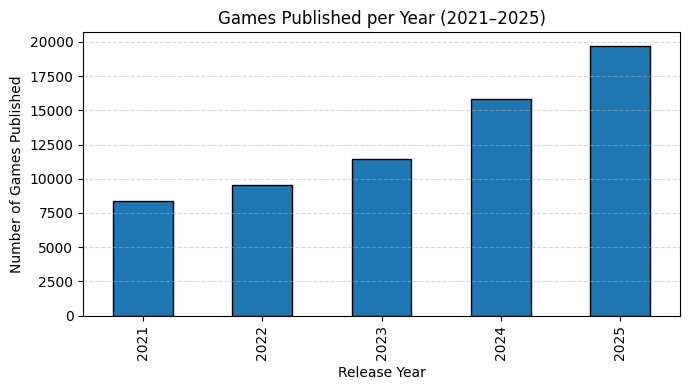

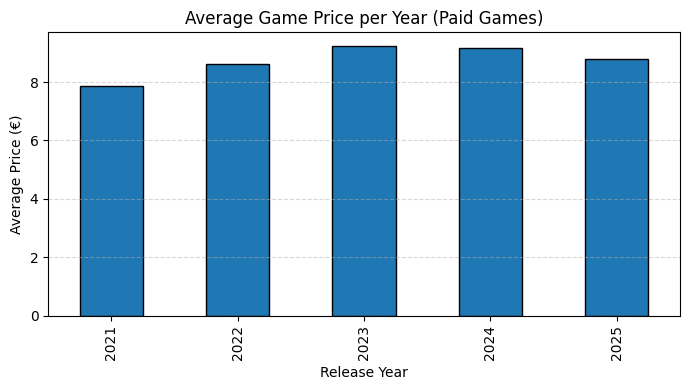

In [ ]:
yearly_counts = steam_df['year'].value_counts().sort_index()

avg_price_per_year = (
    steam_df[steam_df['price'] > 0]
    .groupby('year')['price']
    .mean()
)

plt.figure(figsize=(7, 4))
yearly_counts.plot(kind='bar', edgecolor='black')
plt.xlabel("Release Year")
plt.ylabel("Number of Games Published")
plt.title("Games Published per Year (2021–2025)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("games_published_per_year.png", dpi=300)
plt.show()

plt.figure(figsize=(7, 4))
avg_price_per_year.plot(kind='bar', edgecolor='black')
plt.xlabel("Release Year")
plt.ylabel("Average Price (€)")
plt.title("Average Game Price per Year (Paid Games)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("avg_price_per_year.png", dpi=300)
plt.show()


Convert the release date column to datetime format, ignoring non-specific dates.

Remove entries without a valid calendar release date.

Extract the release month from each game’s release date.

Count how many games were released in each month across all years.

Plot the monthly counts to identify peak publication periods

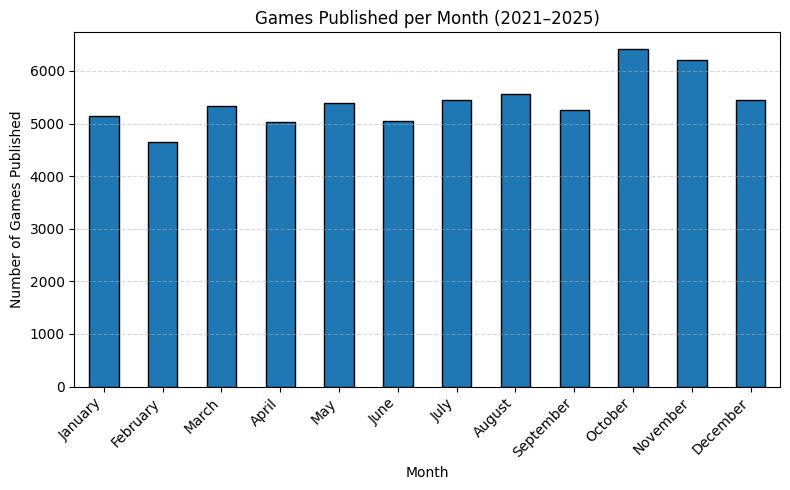

In [63]:
monthly_counts = steam_df['month'].value_counts()

months_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]
monthly_counts = monthly_counts.reindex(months_order)

plt.figure(figsize=(8, 5))
monthly_counts.plot(kind='bar', edgecolor='black')
plt.xlabel("Month")
plt.ylabel("Number of Games Published")
plt.title("Games Published per Month (2021–2025)")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("games_published_per_month.png", dpi=300)
plt.show()


Split the genres string for each game into a list of genres.

Build a complete list of all unique genres in the dataset.

Create a binary matrix where rows are games, columns are genres, and each cell is 1 if the game has that genre (else 0).

Compute a genre–genre distance matrix using Jaccard distance on the binary genre vectors.

Apply MDS to convert the distance matrix into 2D coordinates (one point per genre).

Count how often each genre appears and use this to set the bubble size.

Run k-means on the 2D coordinates to assign each genre to a cluster and use the cluster ID as the bubble color.

Plot the bubbles at the MDS coordinates, label each genre

c:\Users\maxwe\workspace\DSCP-steam-market-analyzer\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:2459: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
c:\Users\maxwe\workspace\DSCP-steam-market-analyzer\.venv\Lib\site-packages\sklearn\manifold\_mds.py:744: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9. To suppress this warning, provide some value of `n_init`.
  warnings.warn(
c:\Users\maxwe\workspace\DSCP-steam-market-analyzer\.venv\Lib\site-packages\sklearn\manifold\_mds.py:754: FutureWarning: The default value of `init` will change from 'random' to 'classical_mds' in 1.10. To suppress this warning, provide some value of `init`.
  warnings.warn(
c:\Users\maxwe\workspace\DSCP-steam-market-analyzer\.venv\Lib\site-packages\sklearn\manifold\_mds.py:771: FutureWarning: The `dissimilarity` parameter is deprecated and will be removed in 1.10. Use `metric` instead.
  warnings.warn(


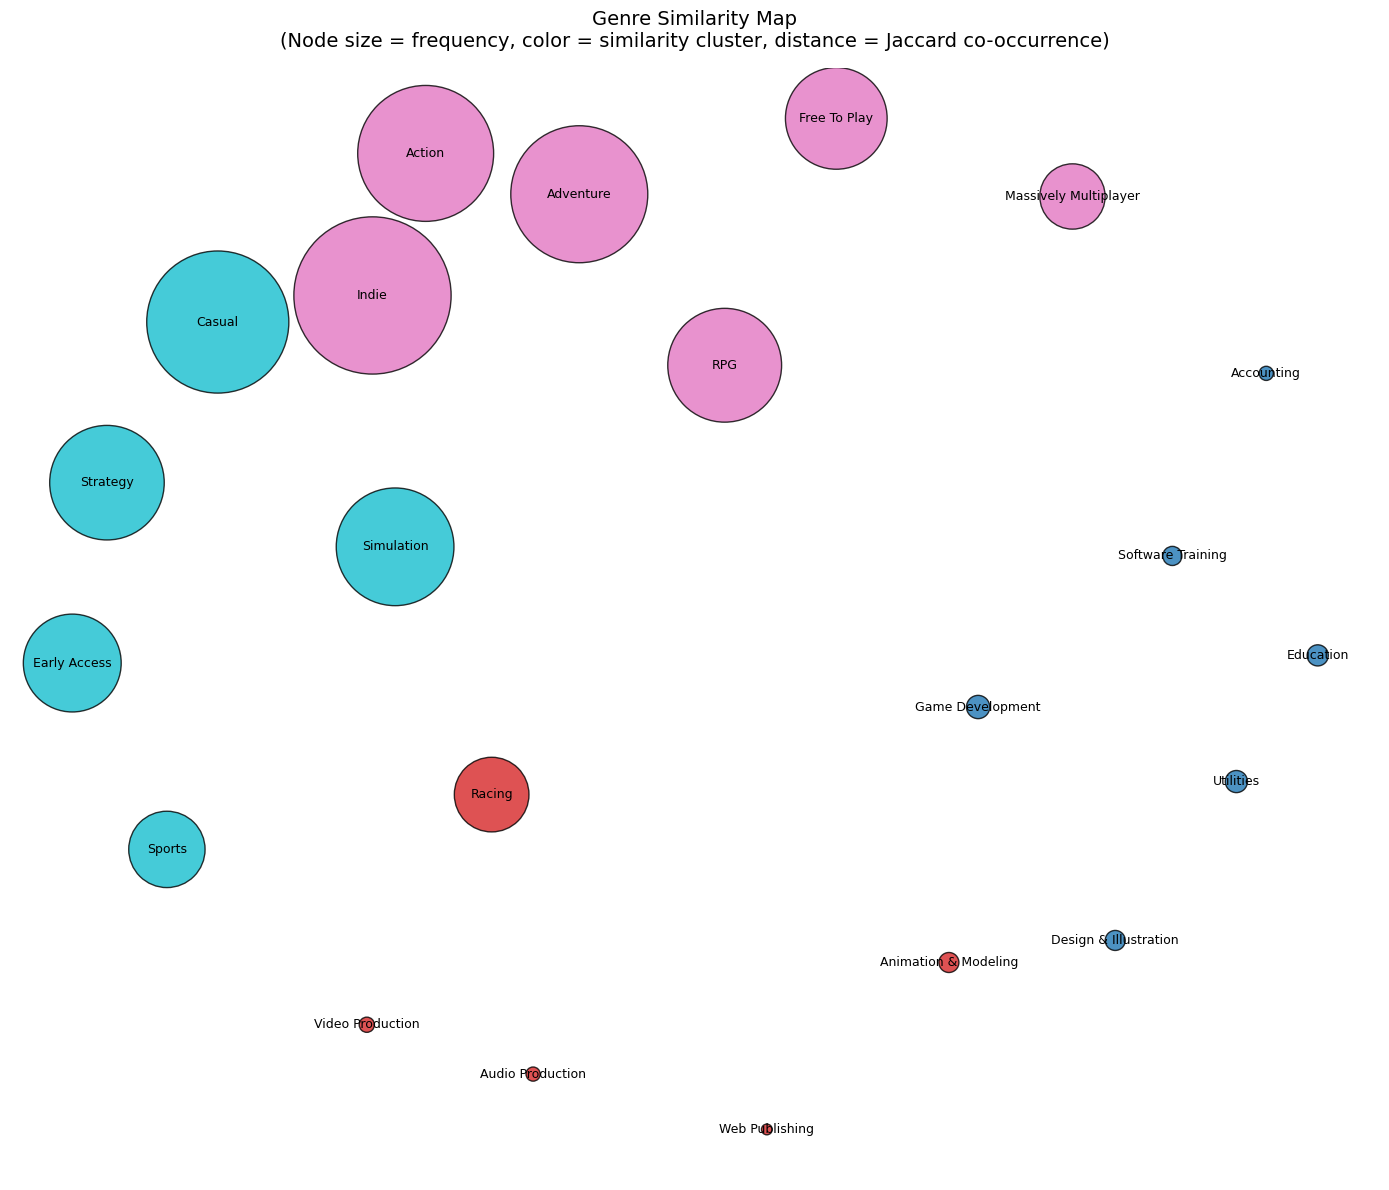

In [64]:
genre_lists = steam_df['genres'].str.split(';')

all_genres = sorted(set(g for genres in genre_lists for g in genres))
genre_index = {g: i for i, g in enumerate(all_genres)}

X = np.zeros((len(genre_lists), len(all_genres)), dtype=int)

for i, genres in enumerate(genre_lists):
    for g in genres:
        X[i, genre_index[g]] = 1

distance_matrix = pairwise_distances(X.T, metric='jaccard')

mds = MDS(
    n_components=2,
    dissimilarity='precomputed',
    random_state=42,
    normalized_stress="auto"
)
coords = mds.fit_transform(distance_matrix)

genre_counts = Counter(g for genres in genre_lists for g in genres)

k = 4
labels = KMeans(n_clusters=k, random_state=42).fit_predict(coords)

plt.figure(figsize=(14, 12))

sizes = [np.sqrt(genre_counts[g]) * 60 for g in all_genres]

scatter = plt.scatter(
    coords[:, 0],
    coords[:, 1],
    s=sizes,
    c=labels,
    cmap='tab10',
    alpha=0.8,
    edgecolors='black'
)

# Labels
for i, g in enumerate(all_genres):
    plt.text(
        coords[i, 0],
        coords[i, 1],
        g,
        ha='center',
        va='center',
        fontsize=9
    )

plt.title(
    "Genre Similarity Map\n"
    "(Node size = frequency, color = similarity cluster, distance = Jaccard co-occurrence)",
    fontsize=14,
    pad=15
)

plt.axis('off')
plt.tight_layout()
plt.savefig("genre_similarity_map.png", dpi=300)
plt.show()


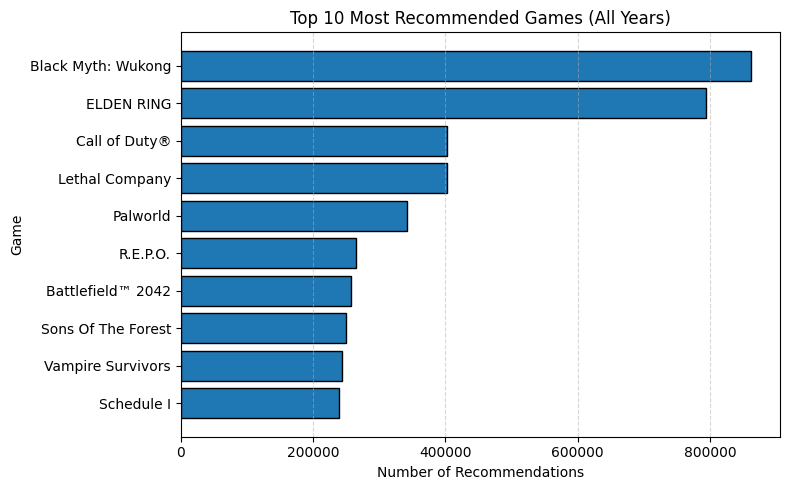

In [65]:
top_games = (
    steam_df[['name', 'recommendations']]
    .sort_values(by='recommendations', ascending=False)
    .head(10)
)

plt.figure(figsize=(8, 5))
plt.barh(top_games['name'], top_games['recommendations'], edgecolor='black')
plt.xlabel("Number of Recommendations")
plt.ylabel("Game")
plt.title("Top 10 Most Recommended Games (All Years)")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("top_10_recommended_games.png", dpi=300)
plt.show()


Convert release dates to datetime format and extract the release year.

Create indicators for whether each game supports single-player or multiplayer.

Group games by year and count single-player and multiplayer titles separately.

Plot a grouped bar chart with two bars per year, one for each play mode.

Use color and a legend to distinguish between single-player and multiplayer games.

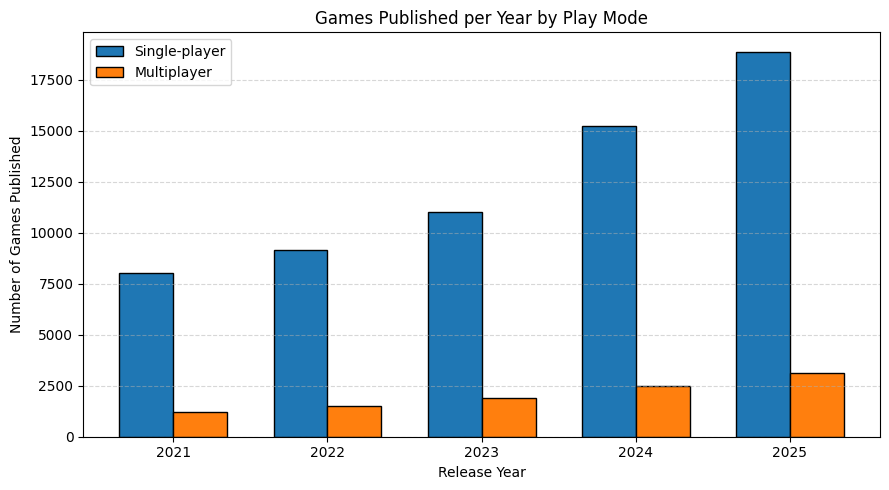

In [66]:
steam_df['is_single'] = steam_df['categories'].str.contains('Single-player', case=False, na=False)
steam_df['is_multi'] = steam_df['categories'].str.contains('Multi-player|Multiplayer', case=False, na=False)

yearly_counts = (
    steam_df
    .groupby('year')[['is_single', 'is_multi']]
    .sum()
    .sort_index()
)

years = yearly_counts.index
x = np.arange(len(years))
width = 0.35

plt.figure(figsize=(9, 5))
plt.bar(
    x - width / 2,
    yearly_counts['is_single'],
    width,
    label='Single-player',
    edgecolor='black'
)

plt.bar(
    x + width / 2,
    yearly_counts['is_multi'],
    width,
    label='Multiplayer',
    edgecolor='black'
)

plt.xlabel("Release Year")
plt.ylabel("Number of Games Published")
plt.title("Games Published per Year by Play Mode")
plt.xticks(x, years)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("single_vs_multi_pa.png", dpi=300)
plt.show()
